## Can RL be used for Classification?
*Let's find out...*

https://www.brthor.com/blog/ai/reinforcement-learning/can-reinforcement-learning-be-used-for-classification/

https://unnatsingh.medium.com/deep-q-network-with-pytorch-d1ca6f40bfda

In [ ]:
import time
import gym
import random
import numpy as np
from easydict import EasyDict as edict 
import os   

import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset 
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
#use_cuda=True and torch.cuda.is_available()
#device = torch.device("cuda" if use_cuda else "cpu")


### Load MNIST Data

In [ ]:
mnist_train = torchvision.datasets.MNIST(root='./mnist_experiment', train=True, download=True,) #'./'
                             #transform=t)

X_mnist_train, y_mnist_train = (mnist_train.data)/255., (mnist_train.targets)
X_mnist_train = X_mnist_train.reshape((len(mnist_train),1,28,28))
#y_mnist_train_one_hot = torch.nn.functional.one_hot(y_mnist_train).reshape((len(mnist_train),1,-1))

mnist_test = torchvision.datasets.MNIST(root= './mnist_experiment',train=False, download=True,)
                             #transform=t)

X_mnist_test, y_mnist_test = (mnist_test.data)/255., (mnist_test.targets)
X_mnist_test =X_mnist_test.reshape((len(mnist_test),1,28,28))
#y_mnist_test_one_hot = torch.nn.functional.one_hot(y_mnist_test).reshape((len(mnist_test),1,-1))


In [ ]:

print("X_mnist_train shape : ",X_mnist_train.shape)
print("y_mnist_train shape : ",y_mnist_train.shape)
#print("y_mnist_train_one_hot shape : ",y_mnist_train_one_hot.shape)


X_mnist_train shape :  torch.Size([60000, 1, 28, 28])
y_mnist_train shape :  torch.Size([60000])


In [ ]:
class customDataset(Dataset):
    ''' 
        Create a dataloader which takes a tuples of mnist data and "one" 
    '''    

    def __init__(self, x_mnist_data, y_mnist_data):
        self.x_mnist_data = x_mnist_data
        
        self.y_mnist_data = y_mnist_data

        
    def __getitem__(self, index):
        sample = {'x': self.x_mnist_data[index], 'y': self.y_mnist_data[index]}
        return sample
        #return (self.x_mnist_data[index], self.y_mnist_data[index])
    
    def __len__(self):
        return len(self.x_mnist_data)

In [ ]:
batch_size = 64

dataset = customDataset(X_mnist_train, y_mnist_train)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True )

dataset_test = customDataset(X_mnist_test , y_mnist_test)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False )


### **Baseline classifier**

In [ ]:
#https://nextjournal.com/gkoehler/pytorch-mnist

nb_classes = 10

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, nb_classes)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [ ]:
#https://visualstudiomagazine.com/articles/2022/02/15/convolutional-neural-networks.aspx

def base_classifer_training(max_epochs = 2,ep_log_interval = 5,lrn_rate = 0.005, train_ldr=train_loader):

    print("\nCreating CNN network")

    use_cuda=True and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    net = Net().to(device)   

    loss_func = nn.CrossEntropyLoss()  # does log-softmax()
    optimizer = optim.Adam(net.parameters(), lr=lrn_rate)
   
    print("loss = " + str(loss_func))
    print("max_epochs = %3d " % max_epochs)
    print("lrn_rate = %0.3f " % lrn_rate)

    print("\nStarting training")
    net.train()  # set mode
    for epoch in range(0, max_epochs):
      ep_loss = 0  # for one full epoch
      #for (batch_idx, batch) in enumerate(train_ldr):
      #  (X, y) = batch  # X = pixels, y = target labels
      for batch_idx, sample in enumerate(train_ldr):                
        X, y = sample['x'], sample['y']
        optimizer.zero_grad()
        oupt = net(X)
        loss_val = loss_func(oupt, y)  # a tensor
        ep_loss += loss_val.item()*len(X)  # accumulate
        loss_val.backward()  # compute grads
        optimizer.step()     # update weights
      #if epoch % ep_log_interval == 0:
      ep_loss /= len(train_ldr.dataset)
      print("epoch = %4d   loss = %0.4f" % \
          (epoch, ep_loss))
    print("Done ")
    
    return net



In [ ]:
def accuracy(model, test_ldr = test_loader):
  test_loss = 0  
  n_correct = 0
  #for data in test_ldr:
  #  (pixels, labels) = data
  for batch_idx, sample in enumerate(test_ldr):                
    pixels, labels = sample['x'], sample['y']    
    with torch.no_grad():
      ouputs = model(pixels)
    (_, predicteds) = torch.max(ouputs, 1)
    n_correct += (predicteds == labels).sum().item()
    loss_func = nn.CrossEntropyLoss(size_average=False) 
    test_loss += loss_func(ouputs, labels).item()

  acc = (n_correct * 1.0) / len(test_ldr.dataset)
  test_loss /= len(test_ldr.dataset)

  print("acc : ",acc)
  print("test loss : ", test_loss)

In [ ]:
basic_model = base_classifer_training()
accuracy(basic_model)


Creating CNN network
loss = CrossEntropyLoss()
max_epochs =   2 
lrn_rate = 0.005 

Starting training
epoch =    0   loss = 0.4282
epoch =    1   loss = 0.2442
Done 


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


acc :  0.9284
test loss :  0.22807685109972953


In [ ]:
mnist_train = torchvision.datasets.MNIST(root='./mnist_experiment', train=True, download=True,) #'./'
                             #transform=t)

X_mnist_train, y_mnist_train = (mnist_train.data)/255., (mnist_train.targets)

np.random.seed(25)
#reduit = np.random.randint(60000,size=5) 
reduit = [0,11000,30000]

X_reduit, y_reduit = X_mnist_train[reduit], y_mnist_train[reduit]
print(" X_reduit", X_reduit.shape)
print(" y_reduit", y_reduit.shape)

In [ ]:
class c1(Dataset):
    ''' 
        Create a dataloader which takes a tuples of mnist data and "one" 
    '''    

    def __init__(self, x_mnist_data, y_mnist_data):
        self.x_mnist_data = x_mnist_data
        
        self.y_mnist_data = y_mnist_data

        
    def __getitem__(self, index):
        sample = {'x': self.x_mnist_data[index], 'y': self.y_mnist_data[index]}
        return sample
        #return (self.x_mnist_data[index], self.y_mnist_data[index])
    
    def __len__(self):
        return len(self.x_mnist_data)

In [ ]:
b_size = 1

d1 = c1(X_reduit, y_reduit)
ldr1 = DataLoader(d1, batch_size=b_size, shuffle=False)


In [ ]:
import matplotlib.pyplot as plt

def plot_batch_image(ldr):
  for batch_idx, sample in enumerate(ldr):                
    image, label = sample['x'], sample['y']
    plt.imshow(np.squeeze(image),cmap = "Greys_r")
    plt.axis("off")
    plt.title(f"label : {label}")
    plt.show()

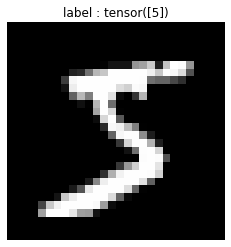

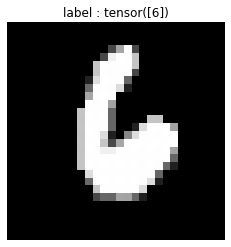

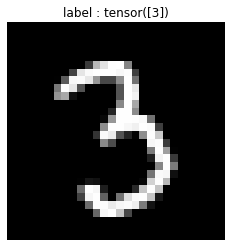

In [ ]:
plot_batch_image(ldr1)

In [ ]:
def cycle(iterable,loops = 2):
    for i in range(loops):
        for x in iterable:
            yield x

In [ ]:
ldr2 = DataLoader(d1, batch_size=b_size, shuffle=True)
#plot_batch_image(cycle(ldr1))
plot_batch_image(cycle(ldr2,3))

In [ ]:
iterloader = cycle(ldr2,2)
examples = enumerate(iterloader)


In [ ]:
batch_idx, examples_dico = next(examples)
plt.imshow(np.squeeze(examples_dico["x"]))
plt.axis("off")
plt.title(f"label : {examples_dico['y']}")
plt.show()

StopIteration: ignored

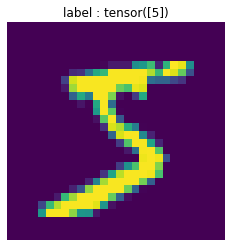

In [ ]:
iterloader = cycle(ldr2,1)
examples_dico = next(iterloader)
plt.imshow(np.squeeze(examples_dico["x"]))
plt.axis("off")
plt.title(f"label : {examples_dico['y']}")
plt.show()

pour le cycle, si on ne lui applique pas enumerate, next ne s'arrête jamais

In [ ]:
##from : https://github.com/facebookresearch/active-mri-acquisition/blob/main/activemri/envs/envs.py
from typing import (
    Any,
    Callable,
    Dict,
    Iterator,
    List,
    Mapping,
    Optional,
    Sequence,
    Sized,
    Tuple,
    Union,
)


class CyclicSampler(torch.utils.data.Sampler):
    def __init__(
        self,
        data_source: Sized,
        order: Optional[Sized] = None,
        loops: int = 1,
    ):
        torch.utils.data.Sampler.__init__(self, data_source)
        assert loops > 0
        assert order is None or len(order) == len(data_source)
        self.data_source = data_source
        self.order = order if order is not None else range(len(self.data_source))
        self.loops = loops

    def _iterator(self):
        for _ in range(self.loops):
            for j in self.order:
                yield j

    def __iter__(self):
        return iter(self._iterator())

    def __len__(self):
        return len(self.data_source) * self.loops     

In [ ]:
class DataHandler:
    def __init__(
        self,
        data_source: torch.utils.data.Dataset,
        seed: Optional[int],
        batch_size: int = 1,
        loops: int = 1,
        collate_fn: Optional[Callable] = None,
    ):
        self._iter = None  # type: Iterator[Any]
        self._collate_fn = collate_fn
        self._batch_size = batch_size
        self._loops = loops
        self._init_impl(data_source, seed, batch_size, loops, collate_fn)

    def _init_impl(
        self,
        data_source: torch.utils.data.Dataset,
        seed: Optional[int],
        batch_size: int = 1,
        loops: int = 1,
        collate_fn: Optional[Callable] = None,
    ):
        rng = np.random.RandomState(seed)
        order = rng.permutation(len(data_source))
        sampler = CyclicSampler(data_source, order, loops=loops)
        if collate_fn:
            self._data_loader = torch.utils.data.DataLoader(
                data_source,
                batch_size=batch_size,
                sampler=sampler,
                collate_fn=collate_fn,
            )
        else:
            self._data_loader = torch.utils.data.DataLoader(
                data_source, batch_size=batch_size, sampler=sampler
            )
        self._iter = iter(self._data_loader)

    def reset(self):
        self._iter = iter(self._data_loader)

    def __iter__(self):
        return self._iter

    def __next__(self):
        return next(self._iter)

    def seed(self, seed: int):
        self._init_impl(
            self._data_loader.dataset,
            seed,
            self._batch_size,
            self._loops,
            self._collate_fn,
        )

In [ ]:
pinedaldr =DataHandler(data_source = d1, #ldr = loader
        seed= 25,
        batch_size = 1,
        loops = 1,
        collate_fn= None)

In [ ]:
plot_batch_image(pinedaldr)

In [ ]:
pinedaldr =DataHandler(data_source = d1, #ldr = loader
        seed= 25,
        batch_size = 1,
        loops = 1,
        collate_fn= None)

examples_pineda = enumerate(pinedaldr)

In [ ]:
batch_idx, examples_pineda_dico = next(examples_pineda)
plt.imshow(np.squeeze(examples_pineda_dico["x"]))
plt.axis("off")
plt.title(f"label : {examples_pineda_dico['y']}")
plt.show()
print(examples_pineda_dico["x"].dtype)

In [ ]:
##run this cell until getting stopIteration
batch_idx, examples_pineda_dico = next(examples_pineda)
plt.imshow(np.squeeze(examples_pineda_dico["x"]))
plt.axis("off")
plt.title(f"label : {examples_pineda_dico['y']}")
plt.show()
print(examples_pineda_dico["x"].dtype)

sans le enumerate, le DataHandler, s'arrête

Conculsion : the cycle function that we created is in someway, equivalent to the DataHandler which incoparates a cyclisampler. They objective is the same, be able to loop over the dataset

In [ ]:
##just to see how permutation work
seed = None
rng = np.random.RandomState(seed)
rng.permutation(10)

array([8, 4, 7, 9, 3, 0, 6, 1, 2, 5])

In [ ]:
np.random.seed(None)
np.random.permutation(10)

array([8, 5, 7, 1, 6, 0, 4, 2, 3, 9])

### Create RL Interface (gym.Env)

**Form the data that will be used**

In [ ]:
mnist_train = torchvision.datasets.MNIST(root='./mnist_experiment', train=True, download=True,) #'./'
                             #transform=t)

X_mnist_train, y_mnist_train = (mnist_train.data)/255., (mnist_train.targets)
X_mnist_train = X_mnist_train.reshape((len(mnist_train),1,28,28))
#y_mnist_train_one_hot = torch.nn.functional.one_hot(y_mnist_train).reshape((len(mnist_train),1,-1))

mnist_test = torchvision.datasets.MNIST(root= './mnist_experiment',train=False, download=True,)
                             #transform=t)

X_mnist_test, y_mnist_test = (mnist_test.data)/255., (mnist_test.targets)
X_mnist_test =X_mnist_test.reshape((len(mnist_test),1,28,28))
#y_mnist_test_one_hot = torch.nn.functional.one_hot(y_mnist_test).reshape((len(mnist_test),1,-1))


In [ ]:

print("X_mnist_train shape : ",X_mnist_train.shape)
print("y_mnist_train shape : ",y_mnist_train.shape)
#print("y_mnist_train_one_hot shape : ",y_mnist_train_one_hot.shape)


In [ ]:
#1 3  10
t = torch.Tensor([1, 2, 3,2,10,5,1,35,5,76,2])
a = (t == 2).nonzero(as_tuple=True)[0]

#np.random.seed(123)
aa = np.random.choice(a, size=1, replace=False)

aa

array([10])

In [ ]:
t[aa]

tensor([2.])

In [ ]:
## We want to reduce the number of training example (and testing example) by taking only a few number of images in each class

def reduce_minst_data(x, y ,nb_image_by_class = 50, seed = 123, shuffle=False):

  indices = []

  for image_label in range(10):
    
    np.random.seed(seed)
    indices_label = np.random.choice((y == image_label).nonzero(as_tuple=True)[0], size=nb_image_by_class, replace=False)
    indices.extend(indices_label)
  
  if shuffle:
    np.random.seed(seed)
    indices = np.random.permutation(indices) 

  return x[indices], y[indices]


In [ ]:
X_train_short, y_train_short = reduce_minst_data(X_mnist_train, y_mnist_train ,nb_image_by_class = 50, seed = 123, shuffle=False)

X_test_short, y_test_short = reduce_minst_data(X_mnist_test, y_mnist_test , nb_image_by_class = 10, seed = 123, shuffle=False)

print("X_train_short shape : ",X_train_short.shape)
print("y_train_short shape : ",y_train_short.shape)
print("X_test_short shape : ",X_test_short.shape)
print("y_test_short shape : ",y_test_short.shape)

X_train_short shape :  torch.Size([500, 1, 28, 28])
y_train_short shape :  torch.Size([500])
X_test_short shape :  torch.Size([100, 1, 28, 28])
y_test_short shape :  torch.Size([100])


(-0.5, 27.5, 27.5, -0.5)

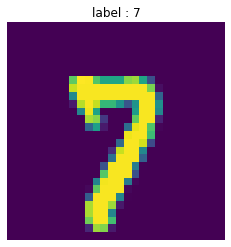

In [ ]:
#checking
index =399
plt.imshow(X_train_short[index].numpy().squeeze())
plt.title(f"label : {y_train_short[index].numpy()}" )
plt.axis("off")

In [ ]:
class customDataset(Dataset):
    ''' 
        Create a dataloader which takes a tuples of mnist data and "one" 
    '''    

    def __init__(self, x_mnist_data, y_mnist_data):
        self.x_mnist_data = x_mnist_data
        
        self.y_mnist_data = y_mnist_data

        
    def __getitem__(self, index):
        sample = {'x': self.x_mnist_data[index], 'y': self.y_mnist_data[index]}
        return sample
        #return (self.x_mnist_data[index], self.y_mnist_data[index])
    
    def __len__(self):
        return len(self.x_mnist_data)

In [ ]:
def cycle(iterable,loops = 2):
    for i in range(loops):
        for x in iterable:
            yield x

In [ ]:

class MnistEnv(gym.Env):
    def __init__(self, n_loops,  device , images_per_episode=1, data = {"x":X_train_short, "y":y_train_short} ):
        super().__init__()

        if device =="cpu": self.device = torch.device("cpu")
        else : self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
        print(f"Running on {device}")
        ##envisager un self.device

        self.loader = cycle(iterable = DataLoader(customDataset(data["x"].to(self.device), data["y"].to(self.device)), 
                                        batch_size = images_per_episode, shuffle=True),
                            loops = n_loops)
        
        self._did_reset = False ##check if we did a reset before pretending to apply step method. otherwise, it could be possible to loop over the data without the reset. it would be possible not to use that variable, and to define the dataloader in the reset method, 
        ##but that will imply to return the loader in the reset and ensure to pass it to the step method. we prefer follow pineda implementaton : https://github.com/facebookresearch/active-mri-acquisition/blob/main/activemri/envs/envs.py#L214
        
        self.iterloader = enumerate(self.loader) ## we could have DataHandler instead of that
        
        self.action_space = gym.spaces.Discrete(10)
        self.observation_space = gym.spaces.Box(low=0, high=1,
                                                shape=(1, 28, 28),
                                                dtype=float)

        self.images_per_episode = images_per_episode
        self.step_count = 0

        print("Finish setting environment")


    def step(self, action):

        if not self._did_reset:
            raise RuntimeError(
                "Attempting to call env.step() before calling env.reset()."
            )

        done = False
        reward = int(action == self.expected_action)

        next_obs = self._next_obs()

        self.step_count += 1
        if self.step_count >= self.images_per_episode: ## dès qu'on aura fait un step, done sera toujous à true
            done = True

        return next_obs, reward, done, {}

    def reset(self):
        self._did_reset = True
        self.step_count = 0

      
        batch_idx, obs = next(self.iterloader) ##first element in the shuffled dataset
        self.expected_action = int(obs['y'])

        return obs #{'x': self.x_mnist_data[index], 'y': self.y_mnist_data[index]}

    def _next_obs(self):

        try:
           batch_idx, obs = next(self.iterloader)

           self.expected_action = int(obs['y'])

           return obs

        except StopIteration: 
            return {}


# The ddqn
it is the same model used in the supervised classification, but here it will predict q-values , rather then class

In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    """ Actor (Policy) Model."""
    def __init__(self, action_size, seed):
        """
        Initialize parameters and build model.
        Params
        =======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork,self).__init__() ## calls __init__ method of nn.Module class
       # self.seed = torch.manual_seed(seed)
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, action_size) ##nb_classes
        
    def forward(self,x):
        # x = state
        """
        Build a network that maps state -> action values.
        """
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x


In the following [this methodology](https://unnatsingh.medium.com/deep-q-network-with-pytorch-d1ca6f40bfda)

In [ ]:

import numpy as np
import random 
from collections import namedtuple, deque 

##Importing the model (function approximator for Q-table)
#from model import QNetwork

import torch
import torch.nn.functional as F
import torch.optim as optim

#BUFFER_SIZE = int(1e5)  #replay buffer size
#BATCH_SIZE = 64         # minibatch size
#GAMMA = 0.99            # discount factor
#TAU = 1e-3              # for soft update of target parameters
#LR = 5e-4               # learning rate
#UPDATE_EVERY = 4        # how often to update the network


## LinearSchedule https://github.com/openai/baselines/blob/ea25b9e8b234e6ee1bca43083f8f3cf974143998/baselines/common/schedules.py#L76 ; we could have also use : 
## https://github.com/facebookresearch/active-mri-acquisition/blob/main/activemri/baselines/ddqn.py#L80 ,  in that link (pineda) it is the espsilon decay wchich is used

## With the LinearSchedule, the epsilon is expected to decrease linearly. We need to know the total number of steps that will be done. in our example of classificaion with RL, we know that
##we went to do 120000 steps (ie loop over the entire training set of 60000 images, 2 times. give the classification of 1 image is one step, the qnet take only one image for a step (in the reconstruction case we will consider a batch),
##but will take a batch from the replay buffer.) 

class LinearSchedule(object):
    def __init__(self, schedule_timesteps, final_p, initial_p=1.0):
        """Linear interpolation between initial_p and final_p over
        schedule_timesteps. After this many timesteps pass final_p is
        returned.
        Parameters
        ----------
        schedule_timesteps: int
            Number of timesteps for which to linearly anneal initial_p
            to final_p
        initial_p: float
            initial output value
        final_p: float
            final output value
        """
        self.schedule_timesteps = schedule_timesteps # by default we will use schedule_timesteps = exploration_fraction * total_timesteps.   exploration_fraction  est la proportion de total_timesteps pendant laquelle l'espsilon va décroitre. par exemple décroitre eps pendant 15000 steps, après le 15000ème step, utiliser final_p
        self.final_p = final_p
        self.initial_p = initial_p

    def value(self, steps_done): 
        #steps_done nb of steps that are already done
        fraction = min(float(steps_done) / self.schedule_timesteps, 1.0)
        return self.initial_p + fraction * (self.final_p - self.initial_p)

class Agent():
    """Interacts with and learns form environment."""
    
    def __init__(self,  config):
        """Initialize an Agent object.
        
        Params
        =======
            config (dict): 
        """
        self.config = config
        self.action_size = config.action_size
        self.seed = random.seed(config.seed)

        if config.device =="cpu": self.device = torch.device("cpu")
        else : self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
        print(f"Running on {self.device}")
        
        
        #Q- Network
        self.qnetwork_local = QNetwork(self.action_size, self.seed).to(self.device)
        self.qnetwork_target = QNetwork(self.action_size, self.seed).to(self.device)
        
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(),lr=config.lr)

        ##espsilon exploration 
        self.exploration = LinearSchedule(schedule_timesteps=int(self.config.exploration_fraction * self.config.total_timesteps),
                              initial_p=self.config.exploration_start_eps,
                              final_p=self.config.exploration_final_eps)
        
        # Replay memory 
        self.memory = ReplayBuffer(self.action_size, config.buffer_size, config.batch_size, config.seed, config.device)
        
        
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0 # number of timesteps dones, equivalent to step_count.step_count
        
    def step(self, obs, action, reward, next_step, done): ##here I assume obs = state, and obs is a dico of image and its label
        # Save experience in replay memory
        self.memory.add(obs, action, reward, next_step, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step+1)% self.config.train_freq
        if self.t_step == 0:
            # If enough samples are available in memory, get radom subset and learn

            if len(self.memory) > self.config.min_length_replay_buffer:
                experience = self.memory.sample()
                self.learn(experience, self.config.gamma)

    def act(self, obs, eps = 0):
        """Returns action for given state as per current policy
        Params
        =======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        image = obs["x"].float().to(self.device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(image)
        self.qnetwork_local.train()

        #Epsilon -greedy action selction
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
            
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        =======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        obs, actions, rewards, next_obs, dones = experiences
        ## TODO: compute and minimize the loss
        criterion = nn.MSELoss().to(self.device)  ##cette loss est destinée au q_values, et non pas au label des images
        self.qnetwork_local.train()
        self.qnetwork_target.eval()
        #shape of output from the model (batch_size,action_dim) = (batch_size,nb_class)
        predicted_targets = self.qnetwork_local(obs["x"]).gather(1,actions)

        #################Updates for Double DQN learning###########################
        self.qnetwork_local.eval()
        with torch.no_grad():
            actions_q_local = self.qnetwork_local(next_obs["x"]).detach().max(1)[1].unsqueeze(1).long()
            labels_next = self.qnetwork_target(next_obs["x"]).gather(1,actions_q_local) ## attention, ne pas confondre ici ces labels avec les labels des images ; les labels ici sont les q-values labels
        self.qnetwork_local.train()
        ############################################################################

        # .detach() ->  Returns a new Tensor, detached from the current graph.
        labels = rewards + (gamma* labels_next*(1-dones)) ### dans le cas de la classification mnist, dones sera tojours un array contenant des 1, comme on considère que la longueur d'épisode est de 1. Et donc normalement, il ne devrait même pas y avoir de next_state (next_obs), puisque le labels_next est multiplié par 0 ; et le gamma risque de ne pas pouvoir jouer son rôle

        loss = criterion(predicted_targets,labels).to(self.device)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local,self.qnetwork_target,tau = self.config.tau)
            
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        =======
            local model (PyTorch model): weights will be copied from
            target model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(),
                                           local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1-tau)*target_param.data)


class ReplayBuffer:
    """Fixed -size buffer to store experience tuples."""
    
    def __init__(self, action_size, buffer_size, batch_size, seed, device):
        """Initialize a ReplayBuffer object.
        
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experiences = namedtuple("Experience", field_names=["obs",
                                                               "action",
                                                               "reward",
                                                               "next_obs",
                                                               "done"])
        self.seed = random.seed(seed)


        if device =="cpu": self.device = torch.device("cpu")
        else : self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
        print(f"Running on {self.device}")
        
    def add(self,obs, action, reward, next_obs,done):
        """Add a new experience to memory."""
        e = self.experiences(obs,action,reward,next_obs,done)
        self.memory.append(e)
        
    def sample(self):
        """Randomly sample a batch of experiences from memory"""

        experiences = random.sample(self.memory,k=self.batch_size)
        
        #obs = {"x" : torch.from_numpy(np.vstack([e.obs["x"] for e in experiences if e is not None])).float().to(self.device) ,  # en réalité on avait pas besoin de train le label, puisqu'on l'utilise seulement dans l'attribution de la récompense, après ça c'est fini,ce n'est plus utiliser
        #      "y" :torch.from_numpy(np.vstack([e.obs["y"] for e in experiences if e is not None])).float().to(self.device) }

        obs = {"x" : torch.from_numpy(np.vstack([e.obs["x"] for e in experiences if e is not None])).float().to(self.device) } 


        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(self.device)

        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)

        #next_obs = {"x" :torch.from_numpy(np.vstack([e.next_obs["x"] for e in experiences if e is not None])).float().to(self.device),
        #              "y" :torch.from_numpy(np.vstack([e.next_obs["y"] for e in experiences if e is not None])).float().to(self.device)}

        next_obs = {"x" :torch.from_numpy(np.vstack([e.next_obs["x"] for e in experiences if e is not None])).float().to(self.device)} ## dans quel cas on aurait None ??

        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
        
        return (obs,actions,rewards,next_obs,dones) #next_obs is nothing else than a new image and its corresponding label, et si jamais on a besoin de son y ??

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


## Train the Agent with DQN

In [ ]:

def train_dqn(config):
    """Deep Q-Learning
       
    """

    config = edict(config)
    
    agent = Agent(config)
    env = MnistEnv(n_loops=config.num_loops_train_data, device=config.device, images_per_episode=1, data = {"x":X_train_short, "y":y_train_short}) 


    scores = [] # list containing score from each episode
    scores_window = deque(maxlen=100) # last 100 scores

    #eps = eps_start

    obs = env.reset()

    epoch = 0
    while obs != {}: ##if next_obs== {}, then we are at the end of our dataset
        
          action = agent.act(obs , agent.exploration.value(env.step_count) )
          next_obs, reward, done, _ = env.step(action)
          agent.step(obs,action,reward,next_obs,done)
          ## above step decides whether we will train(learn) the network
          ## actor (local_qnetwork) or we will fill the replay buffer
          ## if len replay buffer is equal to the min_length_replay_buffer then we will
          ## train the network or otherwise we will add experience tuple in our 
          ## replay buffer.
          obs = next_obs

          if env.step_count%20==0: print(f"we are at step {env.step_count}")

          if reward > 0: correct = 1 ##we know that if rewoard =1, the label is ocrrectly predicted , if 0, it is wrong
          else: correct =0 
          
          scores.append(correct) 

          if len(scores)==len(X_train_short): ##we have done one tour of the training dataset

                print(f"accuracy on training epoch {epoch} is {round(correct/len(X_train_short))}") ## len(X_train_short) should be = total_timesteps

                epoch += 1

                scores = []

    torch.save(agent.qnetwork_local.state_dict(),os.path.join(config.saving_path,'checkpoint.pth') ) 
      
    #return agent.qnetwork_local



In [ ]:
configuration = {
    "images_per_episode":1, ## equivalent to number of parallel episodes in pineda
    "nb_columns_to_acquire":5, ###for reconstrution
    "nb_columns_preselected":2,
    "num_loops_train_data" : 2, #equivalent to number of epoch in supervised learning
    "action_size" : 10, ##mnist number of classes
    "seed" : 25,
    "buffer_size" :100, #10000,
    "batch_size":32, ##batch size in the replay buffer, note that one could specify another batch_size when passing image to dqn
    "gamma":1.0, ## discount factor, dans ce cas de classification mnist, il n'y a pas de récompense à long terme, donc l'action courant est très valorisée
    "tau":1e-3, # for soft update of target parameters
    "lr":1e-4,
    "target_network_update_freq":1000, ##update the target network every `target_network_update_freq` steps
    "learning_starts": 32, #10000,
    "train_freq":4, ##update the model every `train_freq` steps
    "exploration_fraction":0.1,
    "exploration_final_eps":0.01,
    "total_timesteps": 1000, #int(1.2e5), 100 =500*2 # number of , pour rendre automatque on aurait pu le calculer dans l'environnement, avec num_loops_train_data*len(self.train_data_loader.dataset)
    "exploration_start_eps":1.0,
    "min_length_replay_buffer": 32, #100, #taille minimum du replay buffer à atteindre avant de commencer l'apprentissage ie la mise du qnetwork
    "device": "cpu",
    "saving_path":"./"
    }

##we could have also set a frequency of checkpoint saving, and the frequency of evaluating the ddqn on validation/test set. And specify, where to save the checkpoint, and whether or not
##we should save the checkpoint if result on valiation are good or bad relatively to the previous checkpoint.

In [ ]:
train_dqn(configuration)

Running on cpu
Running on cpu
Running on cpu
Finish setting environment
we are at step 20
we are at step 40
we are at step 60
we are at step 80
we are at step 100
we are at step 120
we are at step 140
we are at step 160
we are at step 180
we are at step 200
we are at step 220
we are at step 240
we are at step 260
we are at step 280
we are at step 300
we are at step 320
we are at step 340
we are at step 360
we are at step 380
we are at step 400
we are at step 420
we are at step 440
we are at step 460
we are at step 480
we are at step 500
accuracy on training epoch 0 is 0
we are at step 520
we are at step 540
we are at step 560
we are at step 580
we are at step 600
we are at step 620
we are at step 640
we are at step 660
we are at step 680
we are at step 700
we are at step 720
we are at step 740
we are at step 760
we are at step 780
we are at step 800
we are at step 820
we are at step 840
we are at step 860
we are at step 880
we are at step 900
we are at step 920
we are at step 940
we ar

## Evaluate the agent

In [ ]:
#load the weights from file

def mnist_dqn_eval(config):
    
    config = edict(config)

    env = MnistEnv(n_loops=1, device= config.device, images_per_episode=1, data = {"x": X_test_short,"y": y_test_short}) 
    agent = Agent(config)
    agent.qnetwork_local.load_state_dict(torch.load(os.path.join(config.saving_path,'checkpoint.pth')))

    attempts, correct = 0, 0

    obs = env.reset()

    while obs != {}:
      attempts += 1
      #img = plt.imshow(env.render(mode='rgb_array'))        
      action = agent.act(obs)
      next_obs,reward,done,_ = env.step(action) ##_ is related to info
      obs = next_obs
     
      if reward > 0: correct += 1

    print('Accuracy: {0}%'.format((float(correct)/attempts) * 100))

    env.close()

##10 Novembre 2022, 18h37    



In [ ]:
mnist_dqn_eval(configuration)


Running on cpu
Finish setting environment
Running on cpu
Running on cpu
Accuracy: 11.0%


### Conclusions?

**Remarks**

RL can be used for classification, but it's not the optimal method and doesn't present any advantages over using standard supervised learning. This is purely experimental work (and there might be some mistakes in code)  to launch coding of reconstruction with ddqn